In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("..")
                
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 100)

# viz
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(12.7,10.27)})

# notebook settings
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

import os
os.environ["CUDA_VISIBLE_DEVICES"]="3"

In [3]:
def getTCGA(disease):
    path = "/srv/nas/mk2/projects/pan-cancer/TCGA_CCLE_GCP/TCGA/TCGA_{}_counts.tsv.gz"
    files = [path.format(d) for d in disease]
    return files


def readGCP(files, biotype='protein_coding', mean=True):
    """
    Paths to count matrices.
    """
    data_dict = {}
    for f in files:
        key = os.path.basename(f).split("_")[1]
        data = pd.read_csv(f, sep='\t', index_col=0)
        # transcript metadata
        meta = pd.DataFrame([row[:-1] for row in data.index.str.split("|")],
                            columns=['ENST', 'ENSG', 'OTTHUMG', 'OTTHUMT', 'GENE-NUM', 'GENE', 'BP', 'BIOTYPE'])
        meta = pd.MultiIndex.from_frame(meta)
        data.index = meta
        # subset transcripts
        data = data.xs(key=biotype, level='BIOTYPE')
        data = data.droplevel(['ENST', 'ENSG', 'OTTHUMG', 'OTTHUMT', 'GENE-NUM', 'BP'])
        # average gene expression of splice variants
        data = data.T
        if mean:
            data = data.groupby(by=data.columns, axis=1).mean()
        data_dict[key] = data
    return data_dict


def uq_norm(df, q=0.75):
    """
    Upper quartile normalization of GEX for samples.
    """
    quantiles = df.quantile(q=q, axis=1)
    norm = df.divide(quantiles, axis=0)
    return norm

In [5]:
base = "/srv/nas/mk2/projects/pan-cancer/TCGA_CCLE_GCP"
disease = ['BRCA', 'LUAD', 'KIRC', 'THCA', 'PRAD', 'SKCM']

tcga_files = getTCGA(disease)
tcga_meta = pd.read_csv(os.path.join(base, "TCGA/TCGA_GDC_ID_MAP.tsv"), sep="\t")
tcga_raw = readGCP(tcga_files, mean=True)

In [6]:
# combine samples
tcga_raw = pd.concat(tcga_raw.values())

## LINCS

In [8]:
lincs = pd.read_pickle("/srv/nas/mk2/projects/pan-cancer/LINCS/phase5_test.pkl")
row_lincs = pd.read_pickle("/srv/nas/mk2/projects/pan-cancer/LINCS/phase5_test_rows.pkl")
col_lincs = pd.read_pickle("/srv/nas/mk2/projects/pan-cancer/LINCS/phase5_test_columns.pkl")

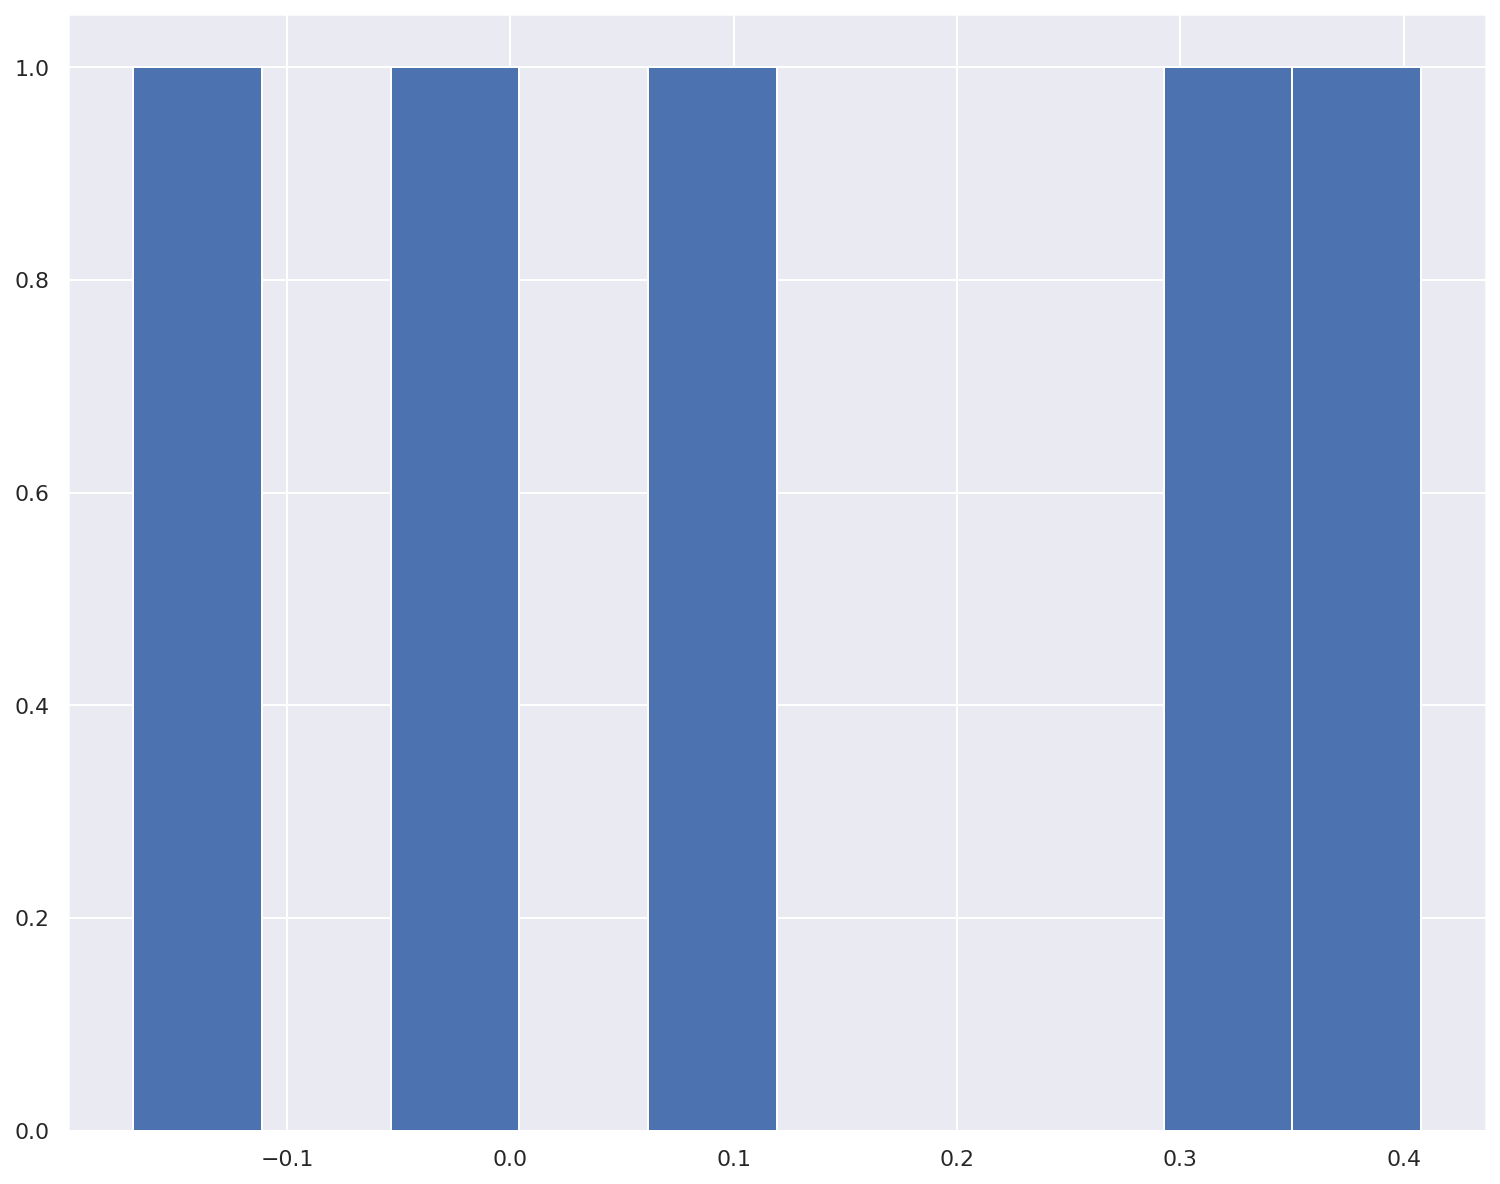

In [43]:
lincs.T.head()['ABCC5'].hist()

In [ ]:
tcga_down = tcga_raw.loc[:,tcga_raw.columns.isin(row_lincs['pr_gene_symbol'])]

In [18]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import StandardScaler

In [29]:
preprocess = make_pipeline(QuantileTransformer(n_quantiles=len(tcga_down), output_distribution='normal'),
                           StandardScaler())

In [30]:
foo = preprocess.fit_transform(tcga_down)

In [31]:
foo = pd.DataFrame(foo, index=tcga_down.index, columns=tcga_down.columns)

In [35]:
foo.head()

GENE,AARS,ABCB6,ABCC5,ABCF1,ABCF3,ABHD4,ABHD6,ABL1,ACAA1,ACAT2,ACBD3,ACD,ACLY,ACOT9,ADAM10,ADAT1,ADCK3,ADGRE5,ADGRG1,ADH5,ADI1,ADO,ADRB2,AGL,AKAP8,AKAP8L,AKR7A2,AKT1,ALAS1,ALDH7A1,ALDOA,ALDOC,AMDHD2,ANKRD10,ANO10,ANXA7,APBB2,APOE,APP,APPBP2,ARFIP2,ARHGAP1,ARHGEF12,ARHGEF2,ARID4B,ARID5B,ARL4C,ARNT2,ARPP19,ASAH1,...,TXNL4B,TXNRD1,UBE2A,UBE2C,UBE2J1,UBE2L6,UBE3B,UBE3C,UBQLN2,UBR7,UFM1,UGDH,USP1,USP14,USP22,USP6NL,USP7,UTP14A,VAPB,VAT1,VAV3,VDAC1,VGLL4,VPS28,VPS72,WASF3,WDR61,WDR7,WDTC1,WFS1,WIPF2,WRB,XBP1,XPNPEP1,XPO7,YKT6,YME1L1,YTHDF1,ZDHHC6,ZFP36,ZMIZ1,ZMYM2,ZNF131,ZNF274,ZNF318,ZNF395,ZNF451,ZNF586,ZNF589,ZW10
e5bcf0a8-2d8b-4213-8b84-cbb4dc5ca23f,-0.522079,-0.434285,1.148221,0.044999,-0.135673,0.107618,-0.849568,-0.930777,0.351425,0.375629,-0.934575,0.404047,-1.327055,-0.669309,-0.845131,-0.842501,-1.201013,-0.294010,-0.832041,-0.511574,-0.985236,-0.750628,0.152060,1.559304,-0.858370,0.341016,1.349721,0.792761,-0.253962,-0.744926,-0.089168,-0.378262,1.498408,0.472157,1.425716,-0.310673,0.079953,1.286493,-1.213784,-1.328546,0.591505,-0.140927,-1.887911,-0.266628,-0.994267,-0.368414,0.351364,-0.298514,-0.843377,-0.641932,...,-0.199312,-1.208652,0.202434,0.669318,-1.547952,1.376288,-0.972335,-1.098475,-0.910184,0.471472,-1.466138,0.794443,-0.600307,-0.108237,-1.009501,-1.873328,-0.893524,0.020504,-0.871761,0.152683,0.945103,-0.131043,0.092240,1.239941,0.800347,-1.269261,0.626188,-1.152996,-0.556097,1.118959,-1.220246,-0.900873,1.067493,-0.328071,-0.882590,0.814806,-0.534055,-0.333245,0.306820,-0.527002,-0.483833,-1.891621,-0.775235,-0.097159,-1.478933,-1.420614,-1.790208,-0.191825,-0.781050,-0.577699
6101cf90-16cc-4603-89de-b04fe37009ab,-1.176047,-0.436303,1.049196,-0.717671,-0.512118,0.660123,-0.310057,0.631418,-0.645704,-0.492117,0.497655,0.591507,-1.066418,-1.092877,-1.273899,0.189954,-0.167563,-0.648728,0.039485,-1.050263,-0.476957,-0.467387,0.250799,-0.577690,0.145873,-0.635165,-0.290176,0.920403,-0.490042,-0.680083,0.554666,-0.989240,0.876192,-0.354684,0.118090,-0.635916,1.005413,0.555381,0.196814,-0.517171,-0.012547,0.505298,-0.868175,0.152683,-0.139691,0.072587,0.109386,0.536185,-0.895356,0.307461,...,-0.526297,-0.208061,-0.386168,0.377602,-0.727257,0.561829,0.183102,0.243227,-0.642739,0.805430,-1.362103,0.087325,-0.248288,-0.453745,0.453745,-0.796127,-0.102080,-0.492115,-0.430778,-0.422727,1.019808,-0.042548,0.066453,-0.778554,0.438856,-0.645095,-0.594430,-1.229378,-0.440882,0.119939,-0.670837,0.657075,1.045989,-1.091750,-0.888955,-0.026014,-0.106387,0.489350,-0.690165,1.155394,0.039484,-0.737658,0.513669,0.434814,-0.381553,0.095314,-0.757946,1.625271,-0.573350,0.418705
41a5b666-fbaf-4080-b6ab-2ea3efcf5341,-0.875359,-0.091657,1.448269,-1.336039,-1.677739,0.302331,-1.491095,-0.644195,-1.154194,-1.831835,-1.891623,-0.170046,-0.960569,0.359252,-1.793300,0.199311,-1.604741,-1.237290,-1.252001,-0.064000,-0.289537,-1.185971,0.582766,-0.116241,-1.600269,1.201001,-1.260141,0.015607,-1.663602,-1.234644,0.221216,0.769445,-0.925696,0.683177,-1.041759,-0.891694,-1.169920,0.019279,-1.542822,-1.048131,-1.262873,-0.731230,-2.052210,-1.093986,-1.866186,-0.846010,0.085400,-1.653870,-1.815446,-2.553831,...,-0.580589,1.032281,-1.123576,1.385965,-1.497671,0.534055,-0.821671,-1.728928,-2.118106,-1.578376,1.001346,-1.121265,-1.728952,-1.302163,-1.374698,-1.457145,-1.852179,-1.147032,-1.071866,-1.315243,0.355987,-0.329363,-1.009501,-0.223099,-0.180614,0.496576,-1.646534,-2.465812,-1.580530,-1.415549,-0.885313,-1.825220,-2.073146,-1.355886,-1.838531,-1.309406,-1.582694,-0.525594,-1.161416,0.867280,-1.204823,-2.100709,0.758763,-2.452865,-1.671067,-2.361847,-1.634634,-0.593698,-2.304614,-1.576242
79d0c682-52c1-4c35-8dd4-5d465061592c,-0.685503,-0.310337,2.313635,0.103310,1.070307,-0.439532,-1.135860,-0.442908,-0.168184,-1.075151,0.846887,-0.434814,0.189331,-1.734500,0.166942,0.241336,0.714499,-1.328545,-0.029075,-1.812228,-2.216064,0.171899,-0.736860,-1.493861,0.544685,-0.210566,1.031234,0.392775,-0.918529,-0.352729,2.254117,-1.522794,1.346307,0.

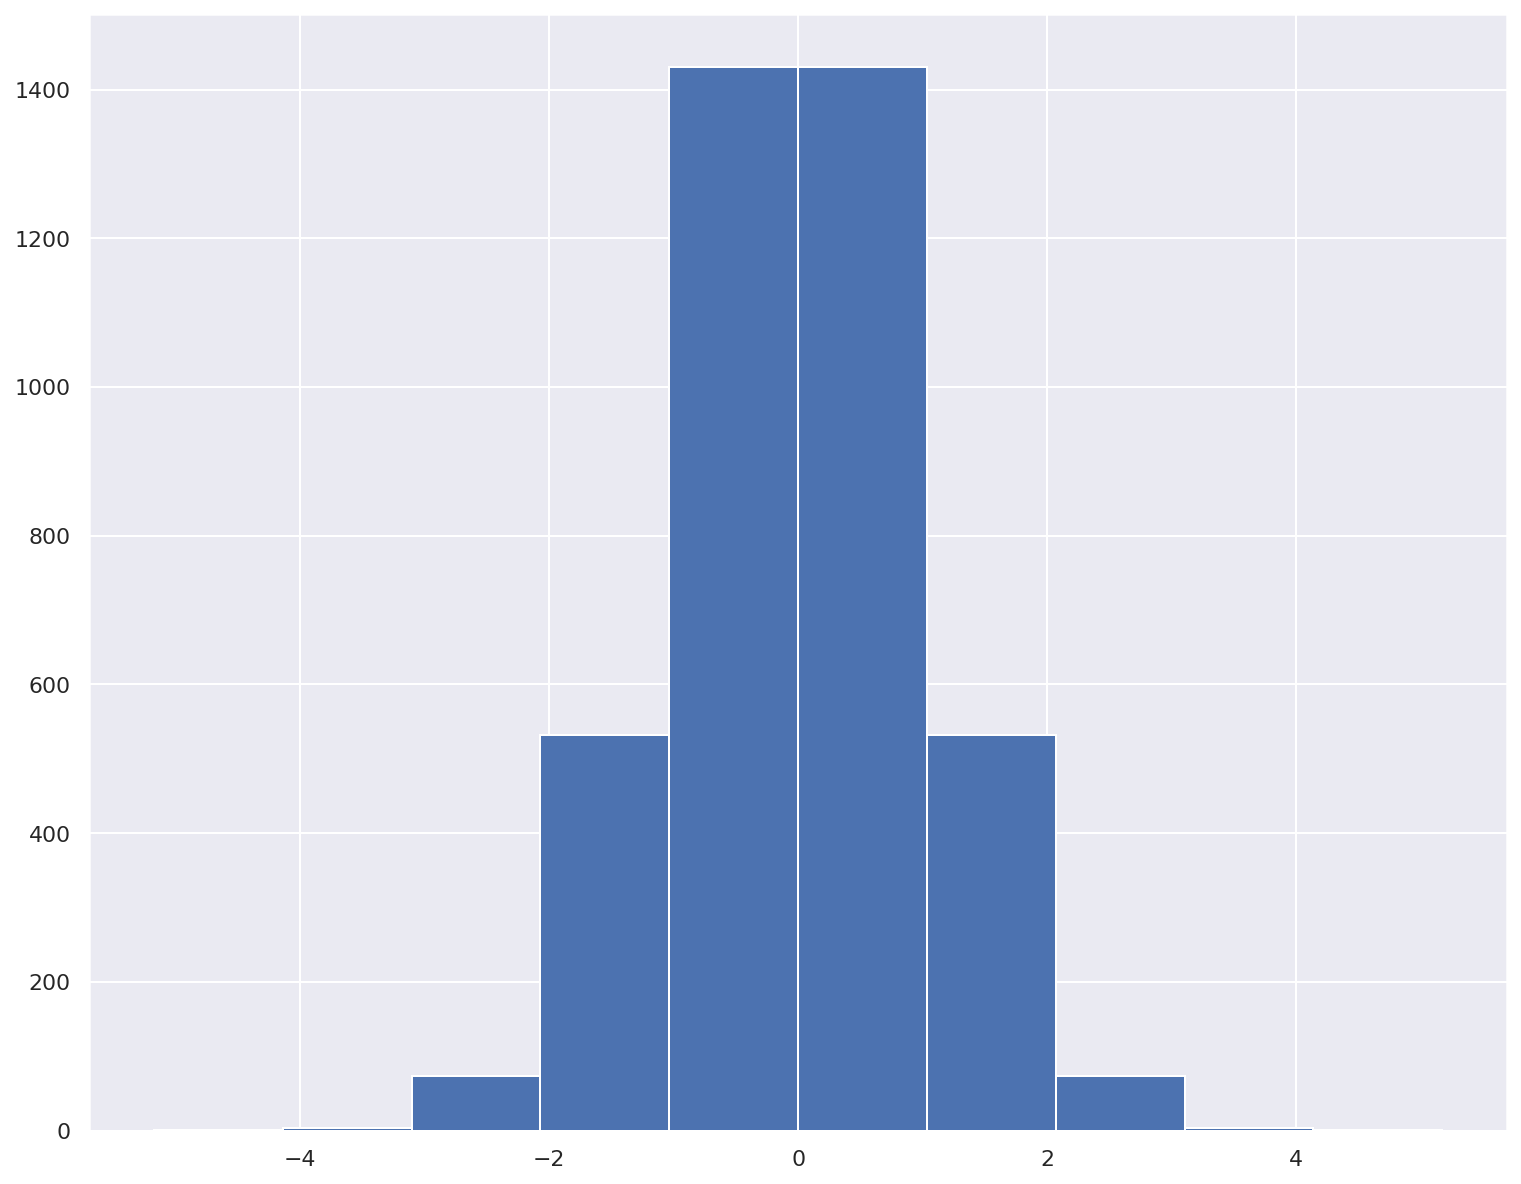

In [32]:
foo.iloc[:,0].hist()

## Normalization

In [6]:
# Upper quartile normalization
tcga_raw = uq_norm(tcga_raw)

In [7]:
# log norm
tcga = tcga_raw.transform(np.log1p)

In [8]:
# downsample
#tcga = tcga_raw.sample(n=40000, axis=1)

# Model

### Experimental Setup

In [9]:
from collections import OrderedDict 
hierarchy = OrderedDict({'Disease':['BRCA', 'LUAD', 'KIRC', 'THCA', 'PRAD', 'SKCM'],
                         'Sample Type':['Primary Tumor', 'Solid Tissue Normal', 'Metastatic']})

In [10]:
from dutils import Experiment
# Define experiment
exp = Experiment(meta_data=tcga_meta,
                 hierarchy=hierarchy,
                 index='CGHubAnalysisID',
                 cases='Case ID',
                 min_samples=20)
# Holdout metastatic
exp.holdout(holdout=['SKCM:Metastatic'])
# Train / Test split
exp.train_test_split(cases='Case ID')
# Return data 
train_data, train_labels = exp.get_data(tcga, subset="train", dtype=np.float32)
test_data, test_labels = exp.get_data(tcga, subset="test", dtype=np.float32)

In [11]:
exp.meta_data['meta'].value_counts()
exp.holdout_meta['meta'].value_counts()

BRCA:Primary Tumor          1119
KIRC:Primary Tumor           542
LUAD:Primary Tumor           536
THCA:Primary Tumor           502
PRAD:Primary Tumor           501
BRCA:Solid Tissue Normal     114
SKCM:Primary Tumor           103
KIRC:Solid Tissue Normal      72
LUAD:Solid Tissue Normal      59
THCA:Solid Tissue Normal      58
PRAD:Solid Tissue Normal      52
SKCM:Metastatic                0
Name: meta, dtype: int64

SKCM:Metastatic             367
THCA:Solid Tissue Normal      0
THCA:Primary Tumor            0
SKCM:Primary Tumor            0
PRAD:Solid Tissue Normal      0
PRAD:Primary Tumor            0
LUAD:Solid Tissue Normal      0
LUAD:Primary Tumor            0
KIRC:Solid Tissue Normal      0
KIRC:Primary Tumor            0
BRCA:Solid Tissue Normal      0
BRCA:Primary Tumor            0
Name: meta, dtype: int64

In [12]:
# Inspect class split distributions
target = 'meta'
case_counts = exp.meta_data[target].value_counts()
exp.train_meta[target].value_counts()[case_counts.index.to_numpy()] / case_counts
exp.test_meta[target].value_counts()[case_counts.index.to_numpy()] / case_counts

BRCA:Primary Tumor          0.786416
KIRC:Primary Tumor          0.800738
LUAD:Primary Tumor          0.843284
THCA:Primary Tumor          0.778884
PRAD:Primary Tumor          0.810379
BRCA:Solid Tissue Normal    0.807018
SKCM:Primary Tumor          0.815534
KIRC:Solid Tissue Normal    0.791667
LUAD:Solid Tissue Normal    0.847458
THCA:Solid Tissue Normal    0.793103
PRAD:Solid Tissue Normal    0.750000
SKCM:Metastatic                  NaN
Name: meta, dtype: float64

BRCA:Primary Tumor          0.213584
KIRC:Primary Tumor          0.199262
LUAD:Primary Tumor          0.156716
THCA:Primary Tumor          0.221116
PRAD:Primary Tumor          0.189621
BRCA:Solid Tissue Normal    0.192982
SKCM:Primary Tumor          0.184466
KIRC:Solid Tissue Normal    0.208333
LUAD:Solid Tissue Normal    0.152542
THCA:Solid Tissue Normal    0.206897
PRAD:Solid Tissue Normal    0.250000
SKCM:Metastatic                  NaN
Name: meta, dtype: float64

In [13]:
import torch
from torch.optim import lr_scheduler
import torch.optim as optim
from torch.autograd import Variable
#torch.manual_seed(123)

from trainer import fit
import visualization as vis
from tcga_datasets import SiameseDataset
import numpy as np
cuda = torch.cuda.is_available()
print("Cuda is available: {}".format(cuda))

Cuda is available: True


# Siamese Network

In [14]:
siamese_train_dataset = SiameseDataset(data=train_data,
                                       labels=train_labels,
                                       train=True)
siamese_test_dataset = SiameseDataset(data=test_data,
                                      labels=test_labels,
                                      train=False)

In [15]:
batch_size = 8
kwargs = {'num_workers': 10, 'pin_memory': True} if cuda else {'num_workers': 10}
siamese_train_loader = torch.utils.data.DataLoader(siamese_train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
siamese_test_loader = torch.utils.data.DataLoader(siamese_test_dataset, batch_size=batch_size, shuffle=False, **kwargs)

# Set up the network and training parameters
from tcga_networks import EmbeddingNet, SiameseNet
from losses import ContrastiveLoss, TripletLoss
from metrics import AccumulatedAccuracyMetric

# Step 2
n_samples, n_features = siamese_train_dataset.train_data.shape
embedding_net = EmbeddingNet(n_features, 2)
# Step 3
model = SiameseNet(embedding_net)
if cuda:
    model.cuda()
    
# Step 4
margin = 1.
loss_fn = ContrastiveLoss(margin)
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 10
# print training metrics every log_interval * batch_size
log_interval = round(len(siamese_train_dataset)/4/batch_size)

SiameseNet(
  (embedding_net): EmbeddingNet(
    (fc): Sequential(
      (linear1): Linear(in_features=19594, out_features=2000, bias=True)
      (relu1): PReLU(num_parameters=1)
      (linear2): Linear(in_features=2000, out_features=500, bias=True)
      (relu2): PReLU(num_parameters=1)
      (linear3): Linear(in_features=500, out_features=250, bias=True)
      (relu3): PReLU(num_parameters=1)
      (linear4): Linear(in_features=250, out_features=100, bias=True)
      (relu4): PReLU(num_parameters=1)
      (linear5): Linear(in_features=100, out_features=50, bias=True)
      (relu5): PReLU(num_parameters=1)
      (linear6): Linear(in_features=50, out_features=10, bias=True)
      (relu6): PReLU(num_parameters=1)
      (linear7): Linear(in_features=10, out_features=2, bias=True)
    )
  )
)

In [16]:
train_loss, val_loss = fit(siamese_train_loader, siamese_test_loader, model, loss_fn, optimizer, scheduler, 
    n_epochs, cuda, log_interval)

Train: [0/2931 (0%)]	Loss: 0.249075
Train: [736/2931 (25%)]	Loss: 0.097456
Train: [1472/2931 (50%)]	Loss: 0.060407
Train: [2208/2931 (75%)]	Loss: 0.051498
Epoch: 1/10. Train set: Average loss: 0.0657
Epoch: 1/10. Validation set: Average loss: 0.0529
Train: [0/2931 (0%)]	Loss: 0.048481
Train: [736/2931 (25%)]	Loss: 0.035707
Train: [1472/2931 (50%)]	Loss: 0.020491
Train: [2208/2931 (75%)]	Loss: 0.016282
Epoch: 2/10. Train set: Average loss: 0.0231
Epoch: 2/10. Validation set: Average loss: 0.0205
Train: [0/2931 (0%)]	Loss: 0.011736
Train: [736/2931 (25%)]	Loss: 0.015318
Train: [1472/2931 (50%)]	Loss: 0.016502
Train: [2208/2931 (75%)]	Loss: 0.015814
Epoch: 3/10. Train set: Average loss: 0.0150
Epoch: 3/10. Validation set: Average loss: 0.0194
Train: [0/2931 (0%)]	Loss: 0.077162
Train: [736/2931 (25%)]	Loss: 0.014985
Train: [1472/2931 (50%)]	Loss: 0.012982
Train: [2208/2931 (75%)]	Loss: 0.011516
Epoch: 4/10. Train set: Average loss: 0.0133
Epoch: 4/10. Validation set: Average loss: 0.0248


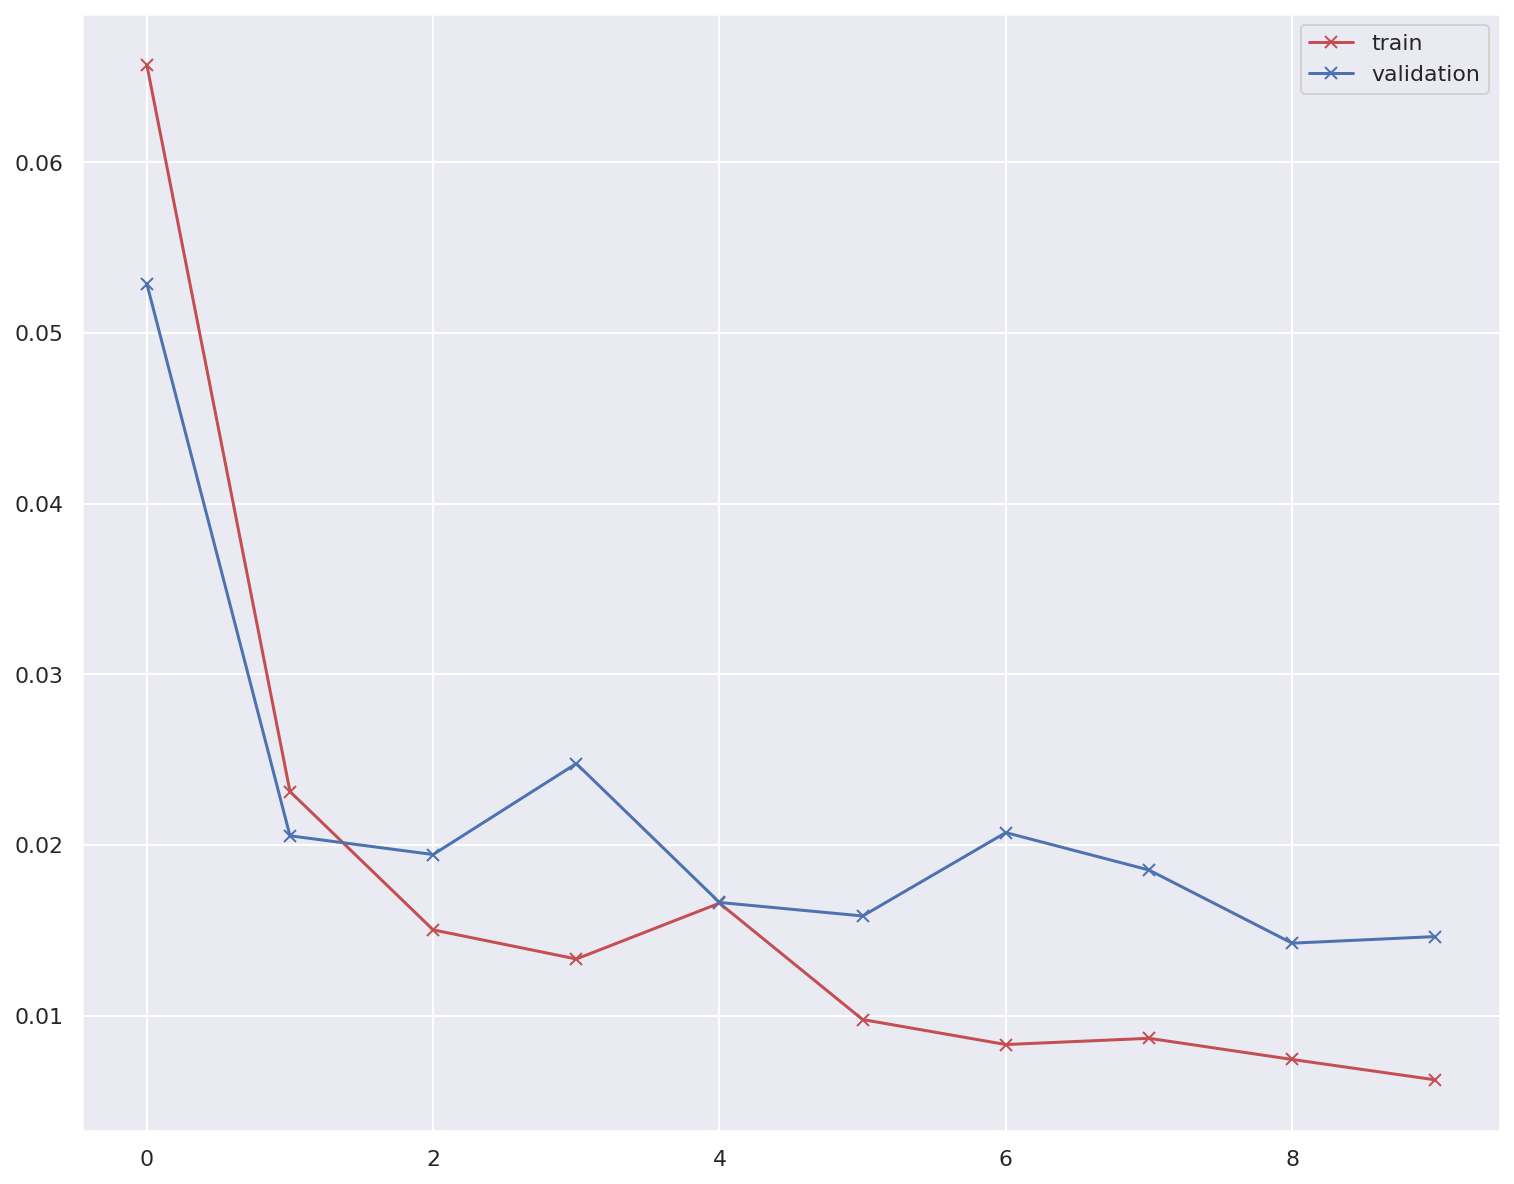

In [17]:
plt.plot(range(0, n_epochs), train_loss, 'rx-', label='train')
plt.plot(range(0, n_epochs), val_loss, 'bx-', label='validation')
plt.legend()

Text(0.5, 1.0, 'PanCancer Train: Siamese')

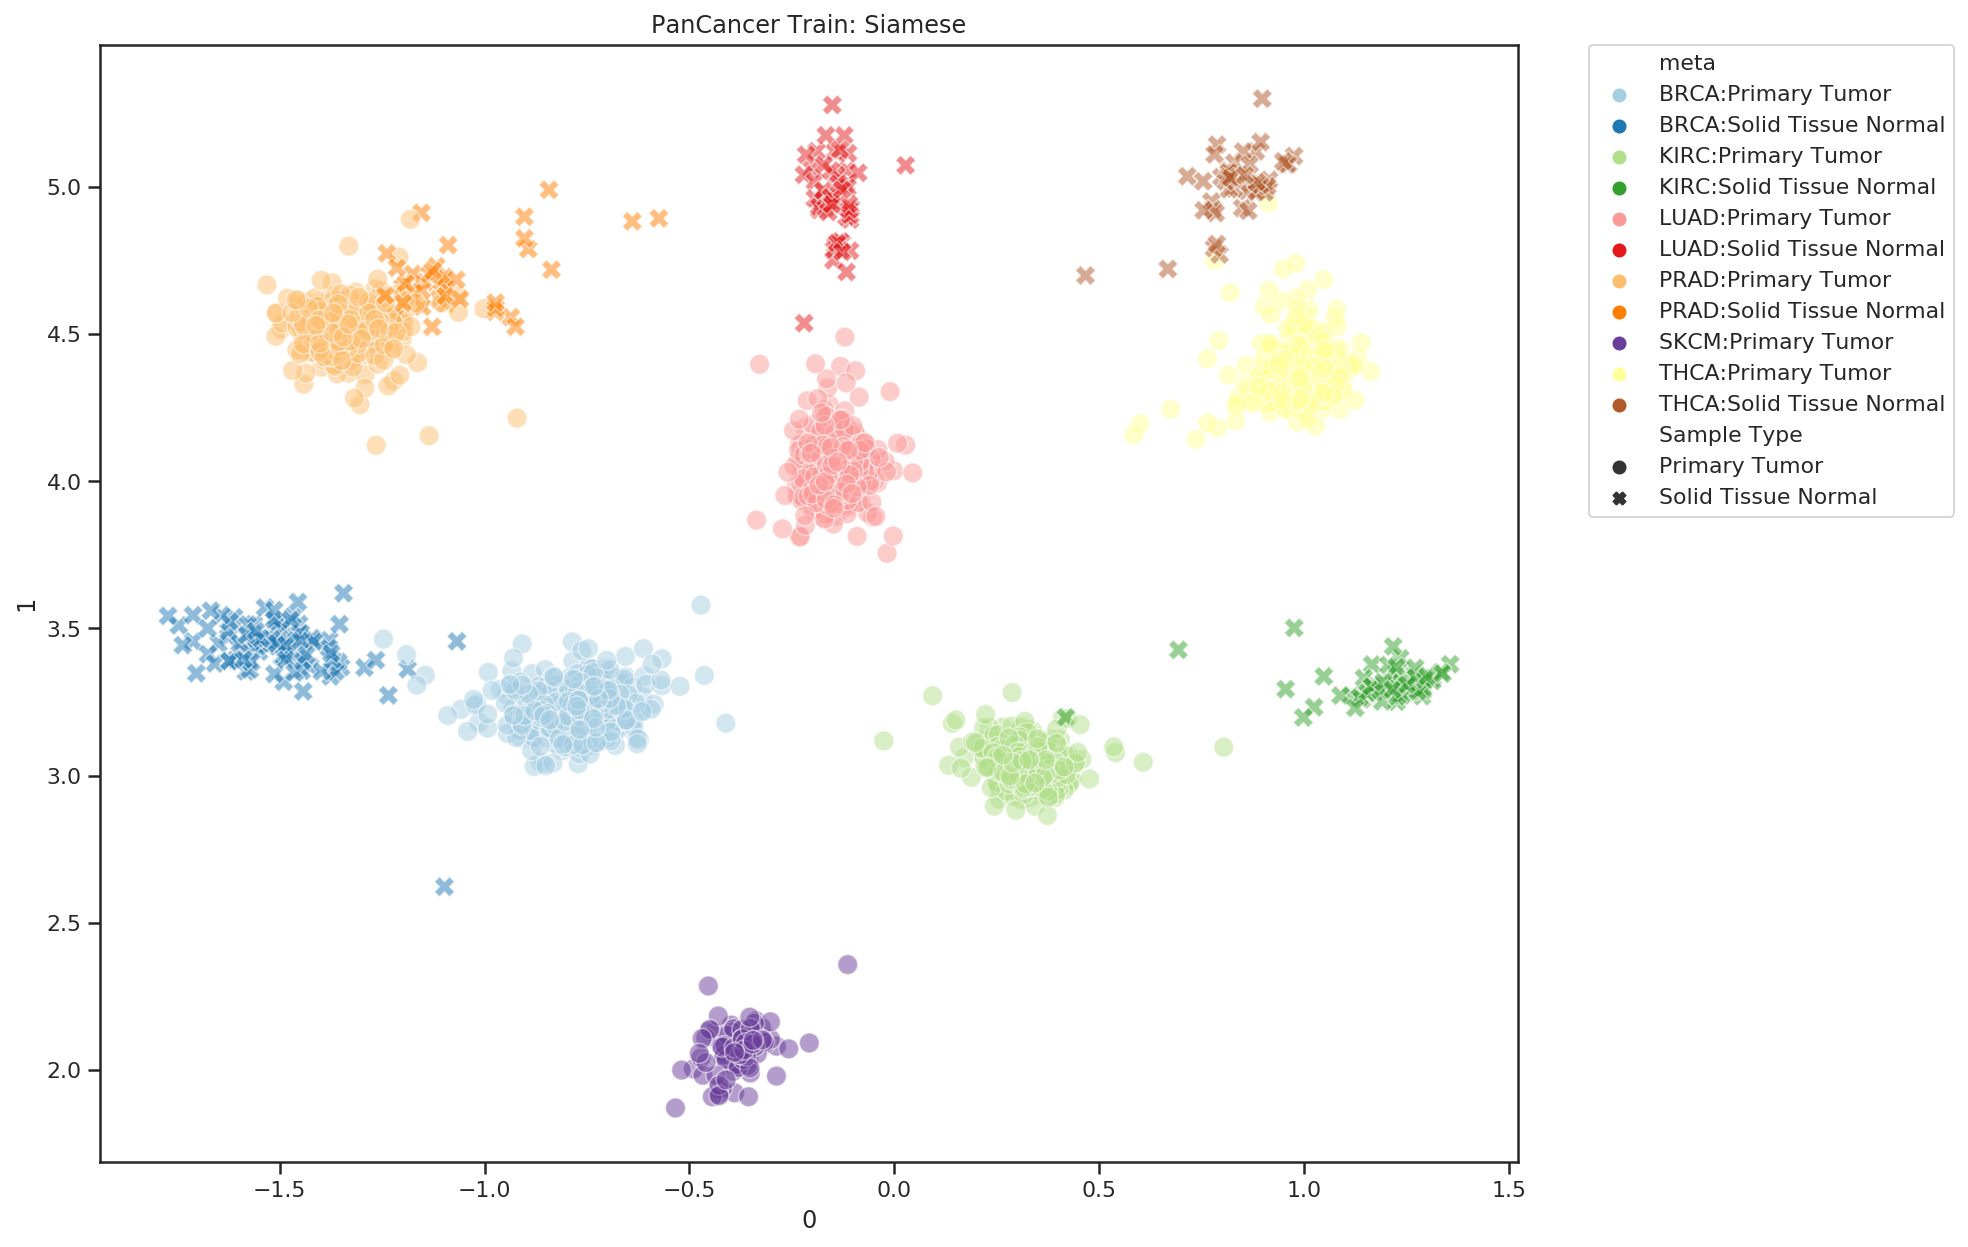

In [18]:
train_embeddings_cl, train_labels_cl = vis.extract_embeddings(siamese_train_dataset.train_data, siamese_train_dataset.labels, model)
vis.sns_plot_embeddings(train_embeddings_cl, train_labels_cl, exp.labels_dict, 
                        hue='meta', style='Sample Type', alpha=0.5)
plt.title('PanCancer Train: Siamese')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

Text(0.5, 1.0, 'PanCancer Test: Siamese')

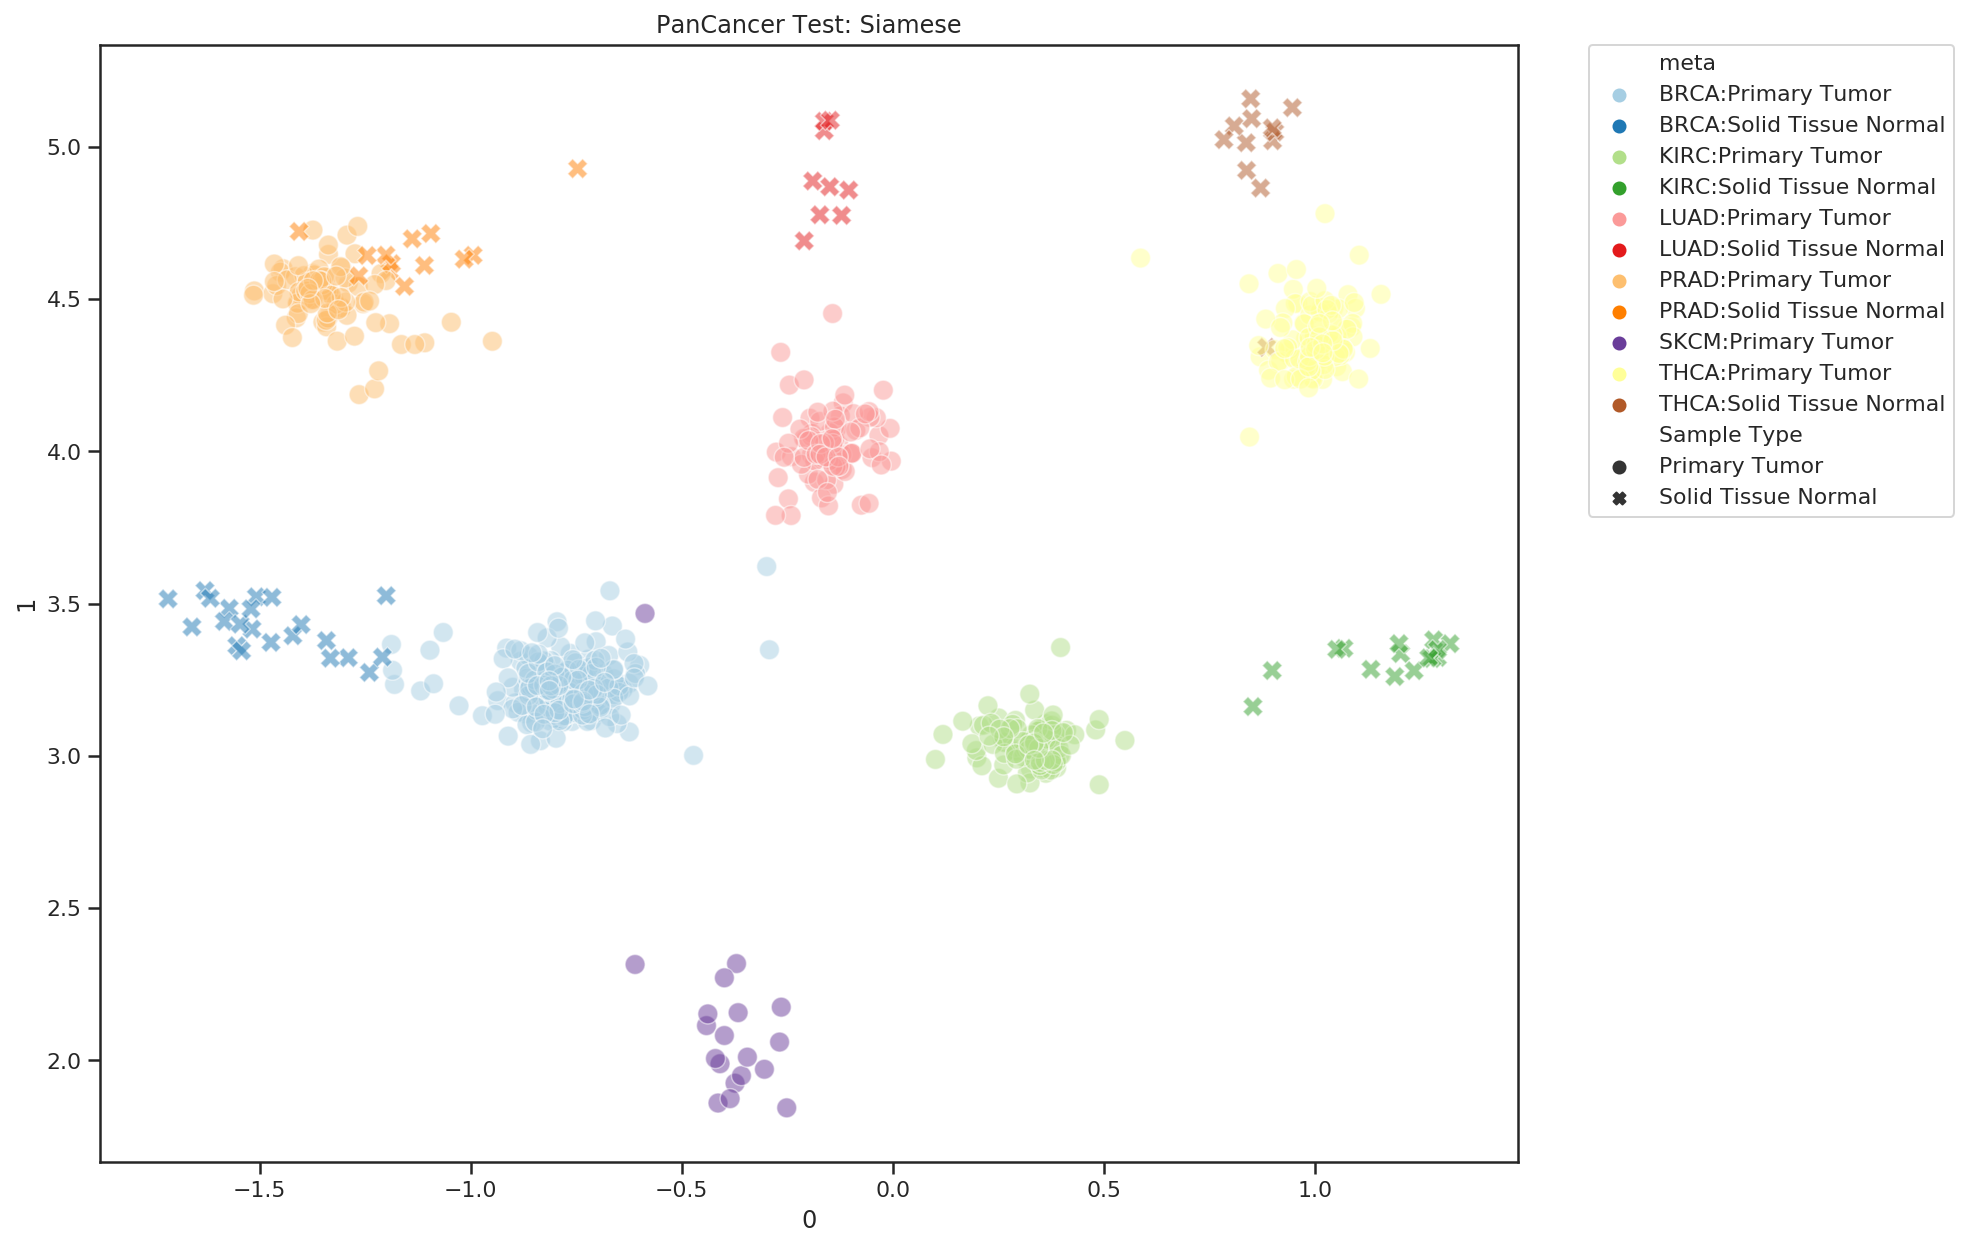

In [19]:
val_embeddings_baseline, val_labels_baseline = vis.extract_embeddings(siamese_test_dataset.test_data, siamese_test_dataset.labels, model)
vis.sns_plot_embeddings(val_embeddings_baseline, val_labels_baseline, exp.labels_dict, 
                        hue='meta', style='Sample Type', alpha=0.5)
plt.title('PanCancer Test: Siamese')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [20]:
holdout_data, holdout_labels = exp.get_data(tcga, subset="holdout", dtype=np.float32)
siamese_holdout_dataset = SiameseDataset(data=holdout_data,
                                         labels=holdout_labels,
                                         train=True)

Text(0.5, 1.0, 'PanCancer Holdout: SKCM:Metastatic')

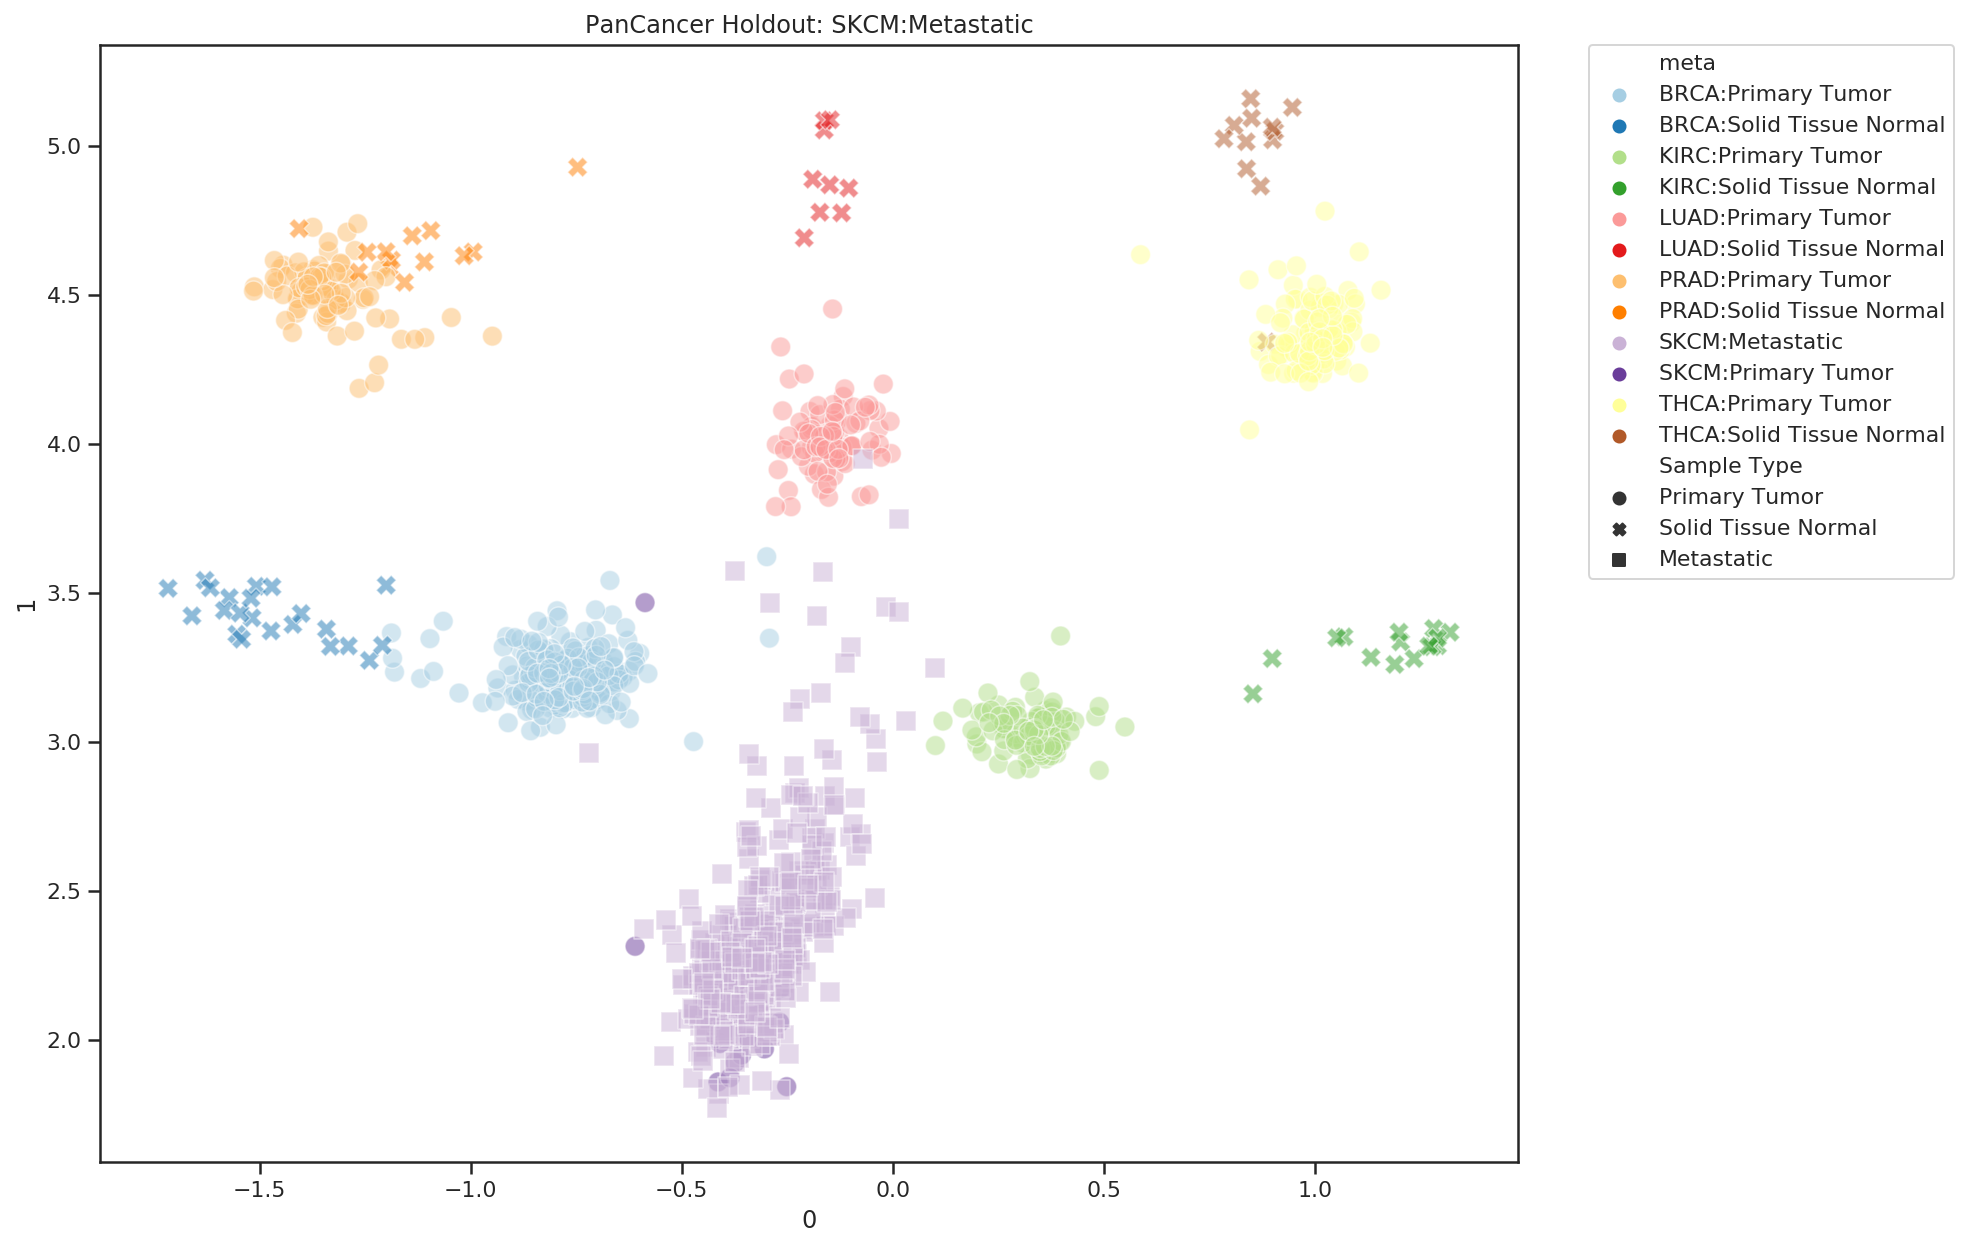

In [21]:
holdout_embeddings_baseline, holdout_labels_baseline = vis.extract_embeddings(siamese_holdout_dataset.train_data, siamese_holdout_dataset.labels, model)
# combine with validation for plotting
comb_embeddings_baseline = np.concatenate((val_embeddings_baseline, holdout_embeddings_baseline))
comb_labels_baseline = np.concatenate((val_labels_baseline, holdout_labels_baseline))
vis.sns_plot_embeddings(comb_embeddings_baseline, comb_labels_baseline, exp.labels_dict, 
                        hue='meta', style='Sample Type', alpha=0.5)
plt.title('PanCancer Holdout: SKCM:Metastatic')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

## CCLE Data for Projection

In [22]:
ccle_file = [os.path.join(base, "CCLE/CCLE_counts.tsv.gz")]

In [23]:
ccle_meta = pd.read_csv(os.path.join(base, "CCLE/CCLE_GDC_Metadata.tsv.gz"), sep="\t")

In [24]:
ccle = readGCP(ccle_file, biotype='protein_coding', mean=True)

In [25]:
# combine samples
ccle = pd.concat(ccle.values())

In [26]:
# normalization
ccle = uq_norm(ccle)
ccle = ccle.transform(np.log1p)

In [27]:
# rename ids to match DepMap 'stripped cell line name'
ccle_ids = ["".join(filter(str.isalnum, i[1])).upper() for i in ccle.index.str.split(".")]
ccle.index = ccle_ids
# drop duplicately named cell lines
ccle = ccle.reset_index().drop_duplicates('index').set_index('index')

In [28]:
# DepMap CCLE metadata
ccle_meta = pd.read_csv('/srv/nas/mk2/projects/pan-cancer/DepMap/CCLE/sample_info_v2.csv', sep=",")

In [29]:
ccle_hierarchy = OrderedDict({'disease':['Breast Cancer', 'Lung Cancer', 'Kidney Cancer', 'Thyroid Cancer', 'Prostate Cancer', 'Skin Cancer'],
                              'primary_or_metastasis':['Primary', 'Metastasis']})

In [30]:
ccle_meta.shape
ccle_meta = ccle_meta[ccle_meta['stripped_cell_line_name'].isin(ccle.index)]
ccle_meta.shape

(1775, 24)

(881, 24)

In [31]:
# Define experiment
ccle_exp = Experiment(meta_data=ccle_meta,
                      hierarchy=ccle_hierarchy,
                      index='stripped_cell_line_name',
                      cases='CCLE_Name',
                      min_samples=1)

In [32]:
ccle_exp.holdout(holdout=ccle_exp.labels_dict.values())

In [33]:
ccle_data, ccle_labels = ccle_exp.get_data(ccle, subset="holdout", dtype=np.float32)
siamese_ccle_dataset = SiameseDataset(data=ccle_data,
                                         labels=ccle_labels,
                                         train=True)

In [34]:
ccle_embeddings_baseline, ccle_labels_baseline = vis.extract_embeddings(siamese_ccle_dataset.train_data, siamese_ccle_dataset.labels, model)

Text(0.5, 1.0, 'PanCancer CCLE Projection')

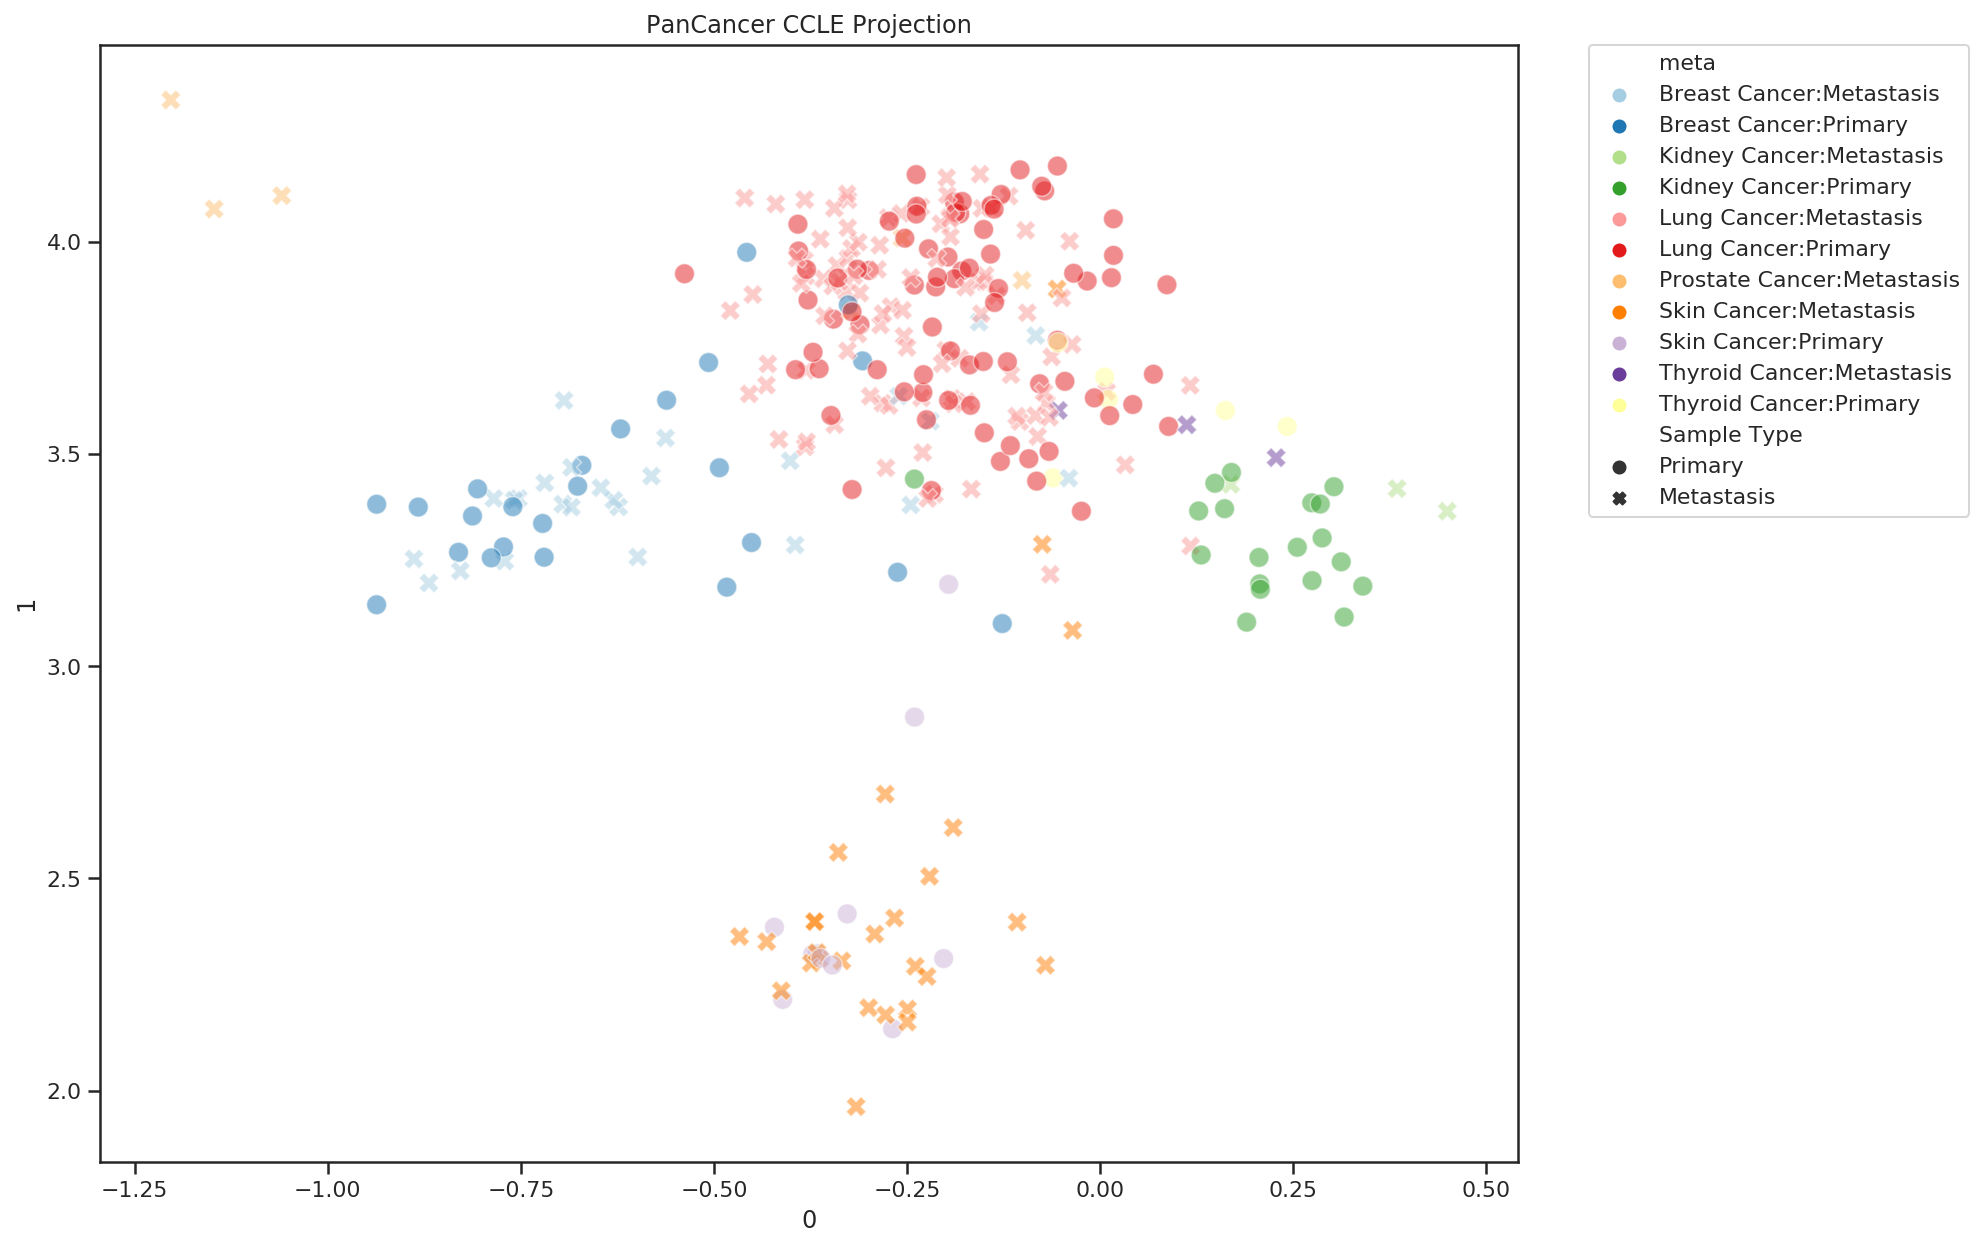

In [35]:
vis.sns_plot_embeddings(ccle_embeddings_baseline, ccle_labels_baseline, ccle_exp.labels_dict, 
                        hue='meta', style='Sample Type', alpha=0.5)
plt.title('PanCancer CCLE Projection')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

## Visualize

In [36]:
tcga_embeddings = pd.DataFrame(val_embeddings_baseline, columns=[0, 1])
tcga_embeddings['id'] = exp.test_meta.index.values
tcga_embeddings['meta'] = exp.test_meta['meta'].values
tcga_embeddings['source'] = np.repeat('TCGA', len(tcga_embeddings))
tcga_embeddings['size'] = np.repeat(20, len(tcga_embeddings))

In [37]:
ccle_embeddings = pd.DataFrame(ccle_embeddings_baseline, columns=[0, 1])
ccle_embeddings['id'] = ccle_exp.holdout_meta.index.values
ccle_embeddings['meta'] = ccle_exp.holdout_meta['meta'].values
ccle_embeddings['source'] = np.repeat('CCLE', len(ccle_embeddings))
ccle_embeddings['size'] = np.repeat(70, len(ccle_embeddings))

In [38]:
all_embeddings = pd.concat([tcga_embeddings, ccle_embeddings])
all_embeddings.shape

(1029, 6)

In [43]:
ccle_exp.holdout

dict_values(['Breast Cancer:Metastasis', 'Breast Cancer:Primary', 'Kidney Cancer:Metastasis', 'Kidney Cancer:Primary', 'Lung Cancer:Metastasis', 'Lung Cancer:Primary', 'Prostate Cancer:Metastasis', 'Skin Cancer:Metastasis', 'Skin Cancer:Primary', 'Thyroid Cancer:Metastasis', 'Thyroid Cancer:Primary'])

Text(0.5, 1.0, 'PanCancer CCLE Projection')

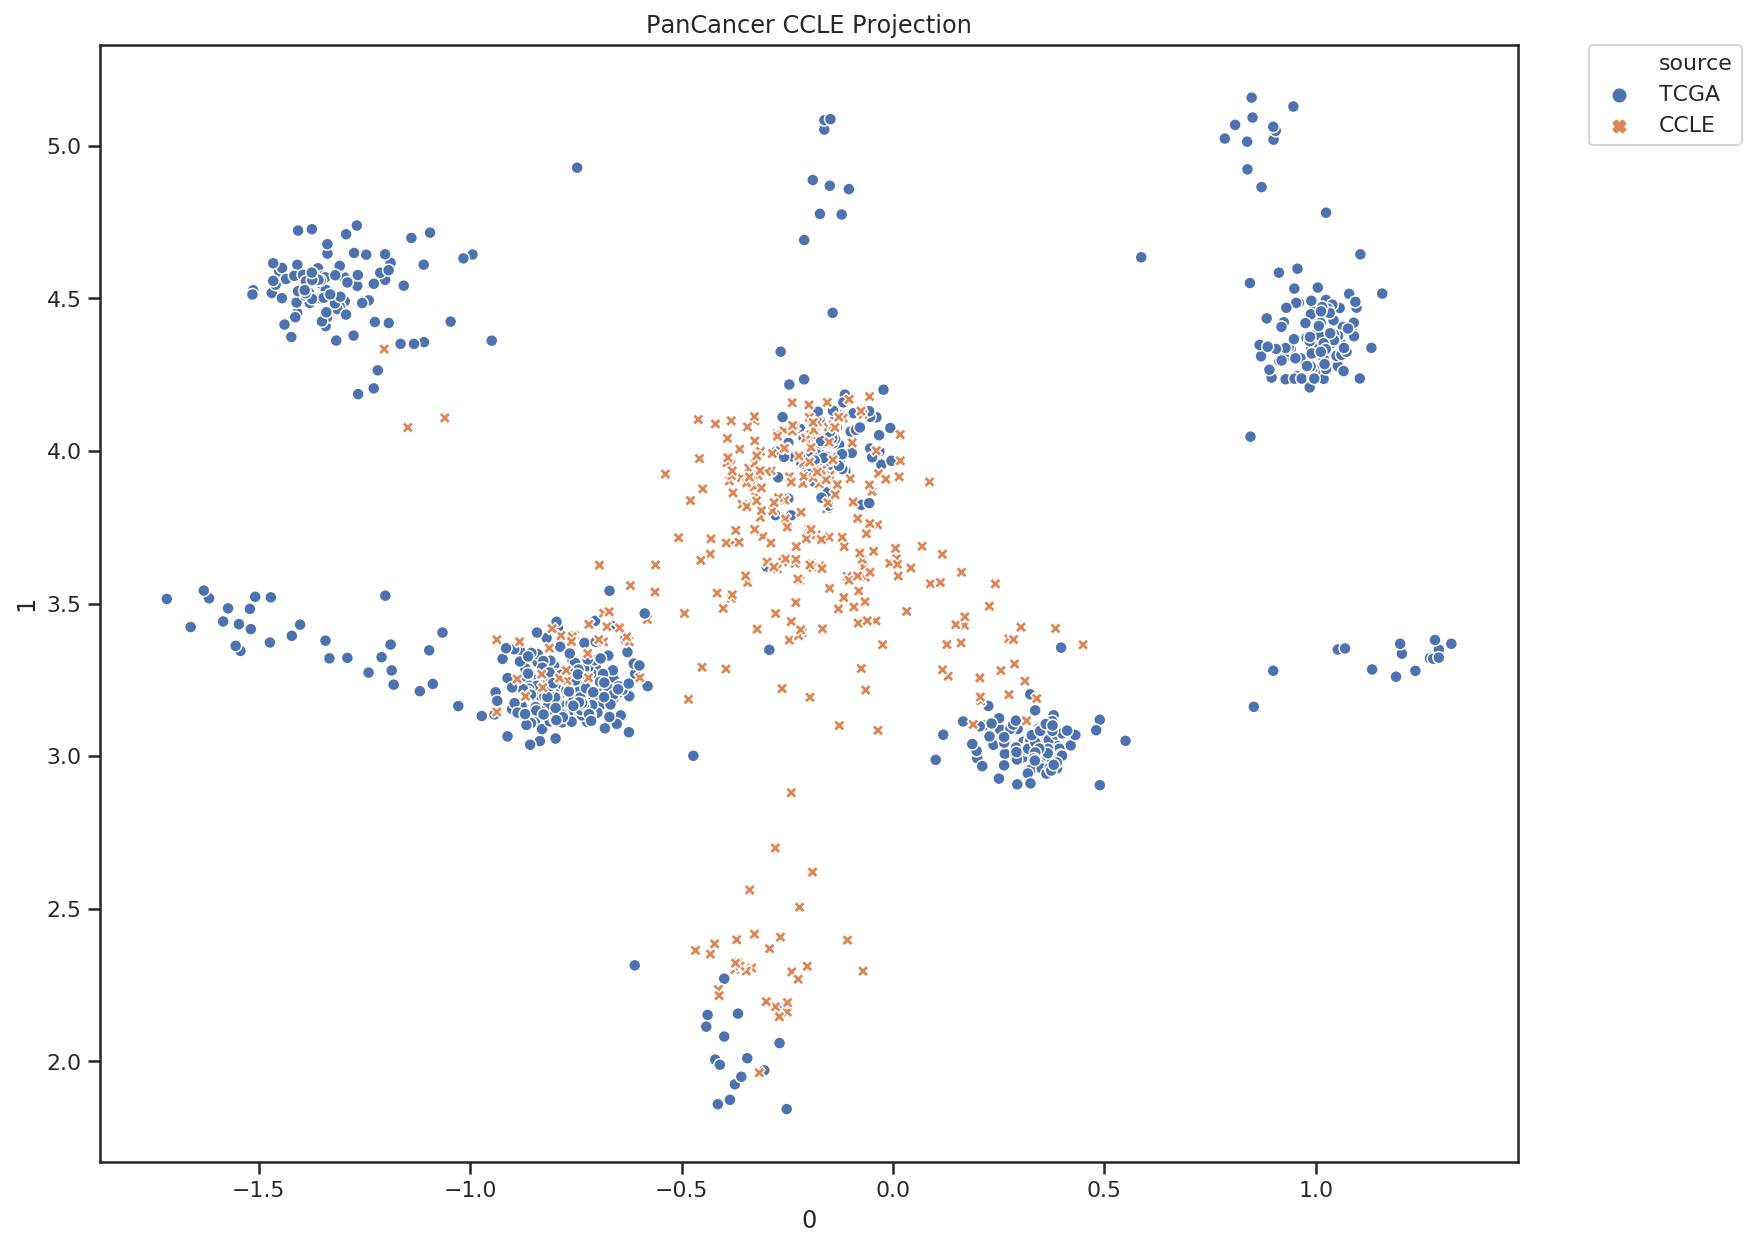

In [44]:
keep = ["Breast Cancer:Primary", "Breast Cancer:Metastasis"]
remove = np.setdiff1d(np.array(ccle_exp.holdout), keep)
select_embeddings = all_embeddings[~all_embeddings['meta'].isin(remove)].sort_values(by='meta')

sns.scatterplot(x=0, y=1, hue='source', style='source', data=select_embeddings)
plt.title('PanCancer CCLE Projection')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

Text(0.5, 1.0, 'PanCancer CCLE Projection')

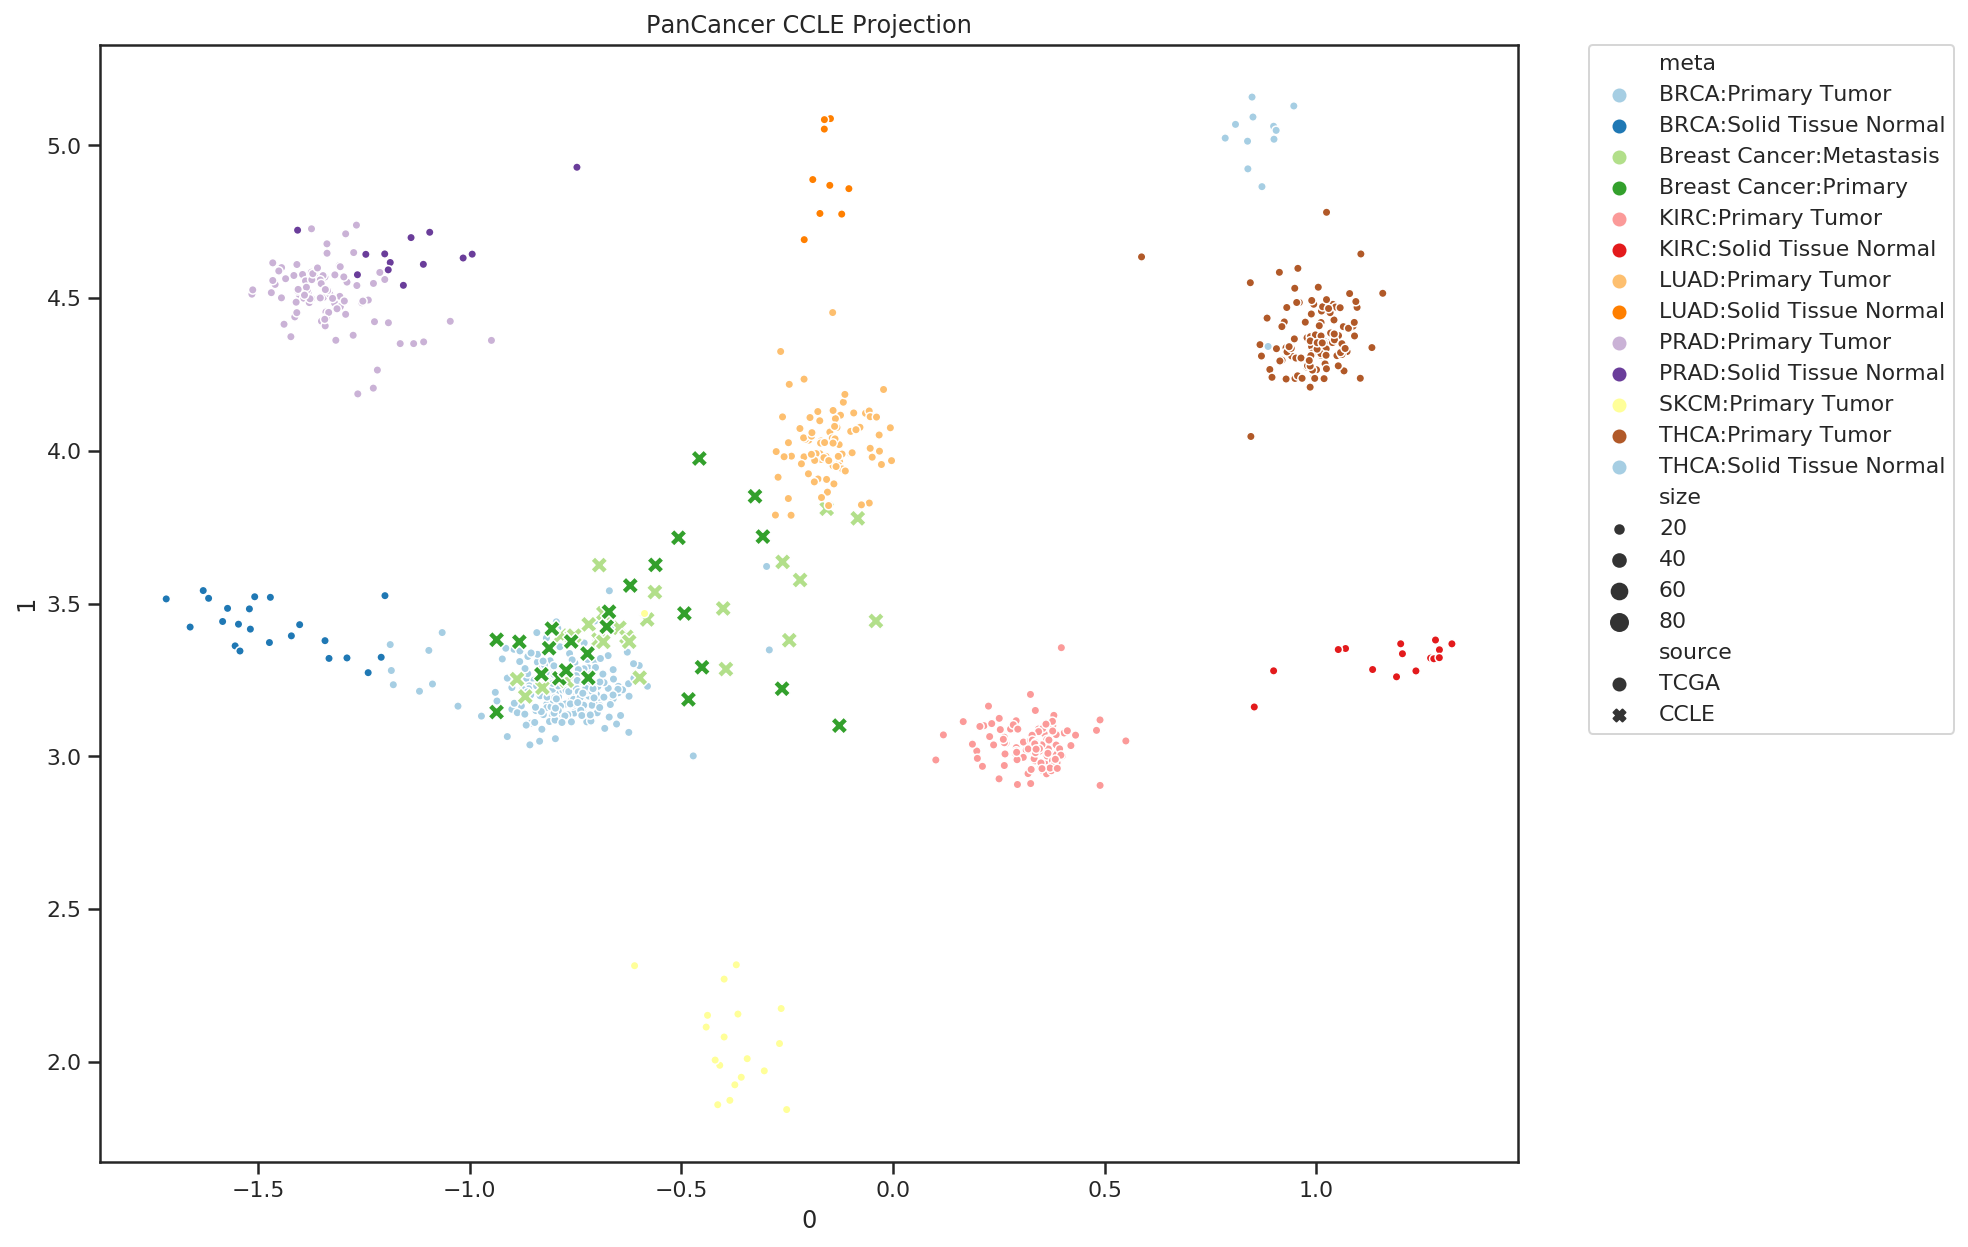

In [47]:
keep = ["Breast Cancer:Primary", "Breast Cancer:Metastasis"]
remove = np.setdiff1d(np.array(list(ccle_exp.holdout)), keep)
select_embeddings = all_embeddings[~all_embeddings['meta'].isin(remove)].sort_values(by='meta')

sns.scatterplot(x=0, y=1, hue='meta', style='source', palette='Paired', size='size', data=select_embeddings)
plt.title('PanCancer CCLE Projection')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [48]:
list(ccle_exp.holdout)

['Breast Cancer:Metastasis',
 'Breast Cancer:Primary',
 'Kidney Cancer:Metastasis',
 'Kidney Cancer:Primary',
 'Lung Cancer:Metastasis',
 'Lung Cancer:Primary',
 'Prostate Cancer:Metastasis',
 'Skin Cancer:Metastasis',
 'Skin Cancer:Primary',
 'Thyroid Cancer:Metastasis',
 'Thyroid Cancer:Primary']

Text(0.5, 1.0, 'PanCancer CCLE Projection')

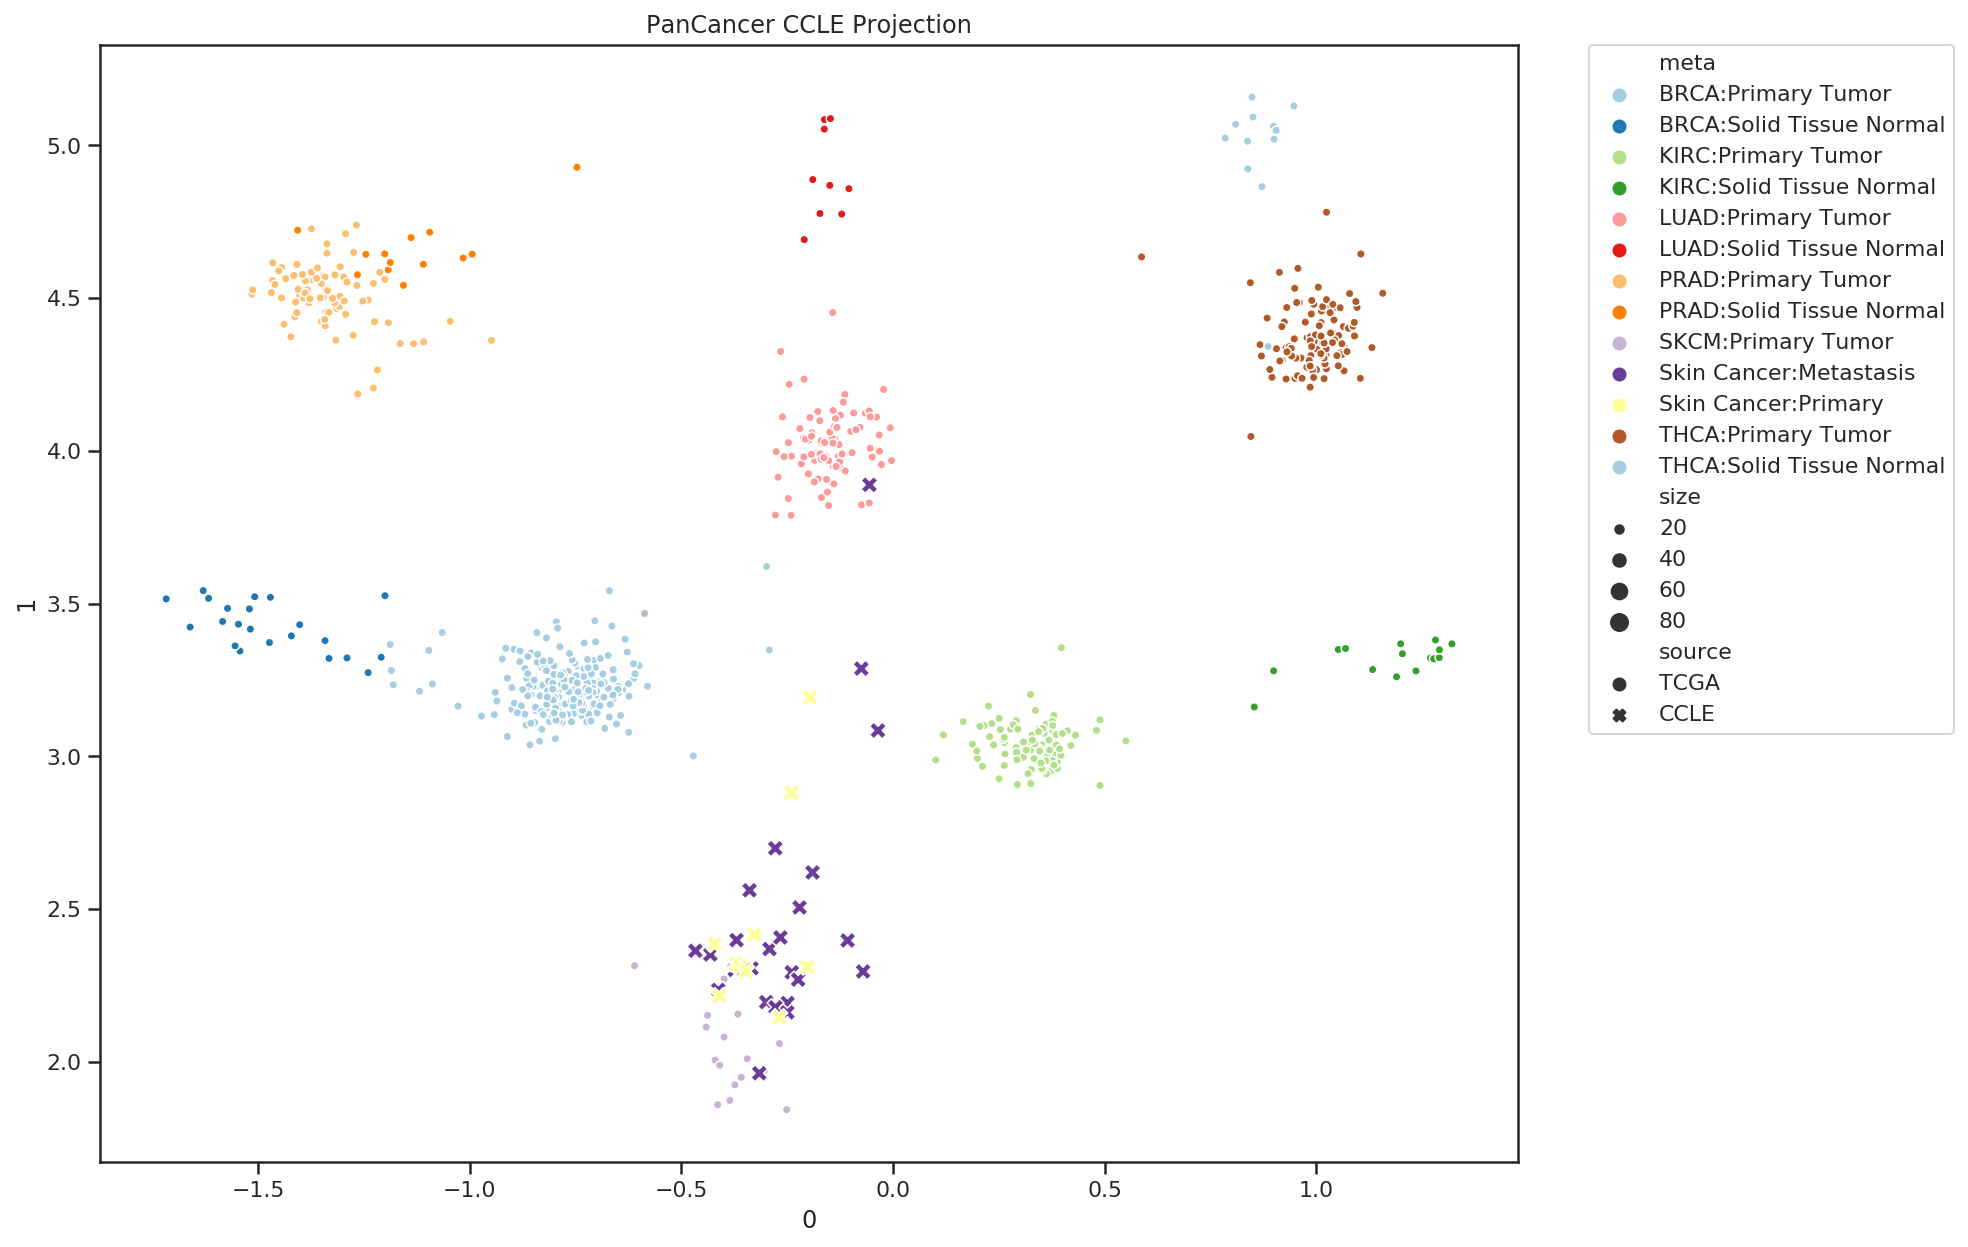

In [49]:
keep = ["Skin Cancer:Primary", "Skin Cancer:Metastasis"]
remove = np.setdiff1d(np.array(list(ccle_exp.holdout)), keep)
select_embeddings = all_embeddings[~all_embeddings['meta'].isin(remove)].sort_values(by='meta')

sns.scatterplot(x=0, y=1, hue='meta', style='source', palette='Paired', size='size', data=select_embeddings)
plt.title('PanCancer CCLE Projection')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

## Evaluation

In [251]:
from sklearn.metrics import pairwise_distances

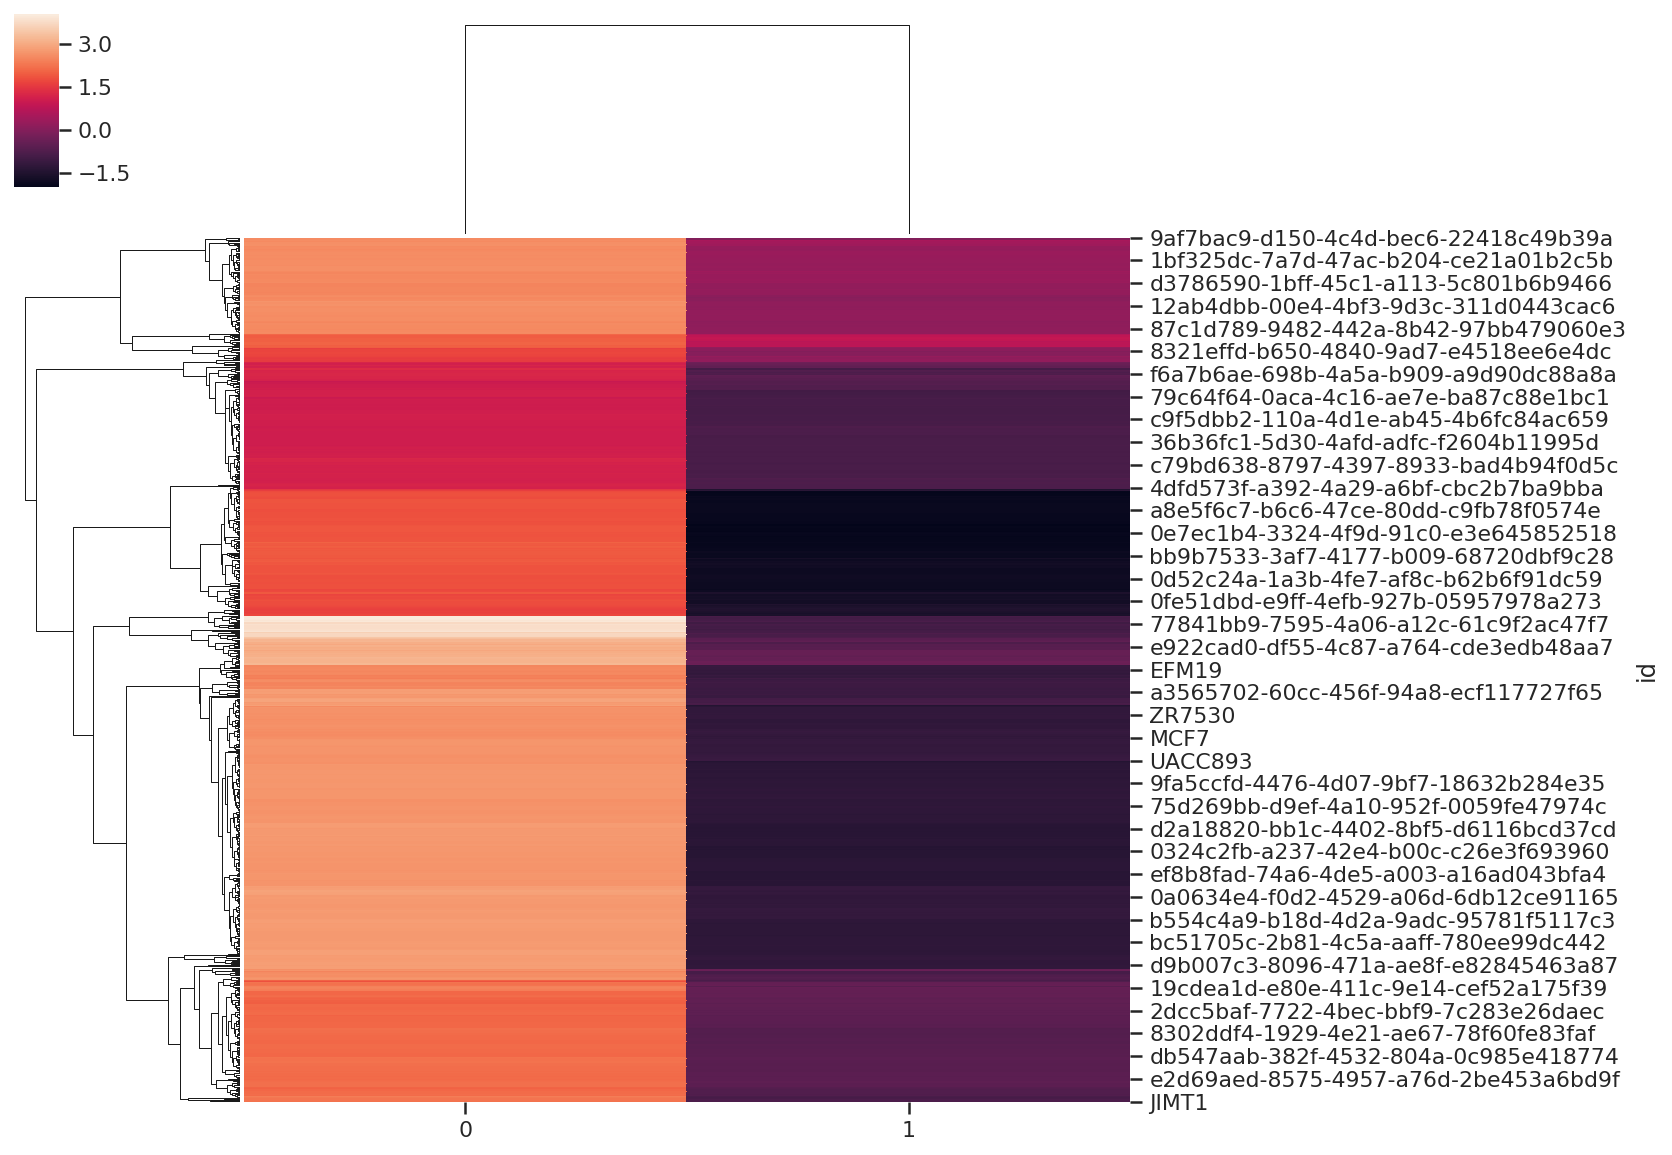

In [255]:
sns.clustermap(select_embeddings.set_index('id').loc[:,[0,1]])

In [253]:
select_distances = pd.DataFrame(pairwise_distances(select_embeddings.set_index('id').loc[:,[0,1]], metric='euclidean'),
                                index=select_embeddings['id'],
                                columns=select_embeddings['id'])